![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Проект 3: О вкусной и здоровой пище
## Predict TripAdvisor Rating
### В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* Применим ML модель для предсказания рейтингов ресторана   


# import

In [18]:
# Импортируем необходимые библиотеки
import pandas as pd

import numpy as np

import gensim
from gensim import corpora
from pprint import pprint

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

import re

import datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import seaborn as sns 

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot

import folium

pyo.init_notebook_mode(connected=True)
cf.go_offline()

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

C:\Users\1311959\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 25

In [20]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [21]:
DATA_DIR = 'C:/Users/1311959/Desktop/python'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [23]:
df_train.head(5)

Restaurant_id       City                                      Cuisine Style  \
0       id_5569      Paris            ['European', 'French', 'International']   
1       id_1535  Stockholm                                                NaN   
2        id_352     London  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...   
3       id_3456     Berlin                                                NaN   
4        id_615     Munich  ['German', 'Central European', 'Vegetarian Fri...   

   Ranking  Rating Price Range  Number of Reviews  \
0   5570.0     3.5    $$ - $$$              194.0   
1   1537.0     4.0         NaN               10.0   
2    353.0     4.5        $$$$              688.0   
3   3458.0     5.0         NaN                3.0   
4    621.0     4.0    $$ - $$$               84.0   

                                             Reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...   
2  [['Catch up with friends', 'Not exceptional'],...   
3                                           [[], []]   
4  [['Best place to try a Bavarian food', 'Nice b...   

                                              URL_TA     ID_TA  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...  d1912643  
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...  d7992032  
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...  d8632781  
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...  d1358776  
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...  d6864963

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [25]:
df_test.head(5)

Restaurant_id        City  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       Cuisine Style  Ranking Price Range  \
0                                     ['Bar', 'Pub']  12963.0    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   Number of Reviews                                            Reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              URL_TA      ID_TA  
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918  
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944  
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638  
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417  
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354

In [26]:
sample_submission.head(5)

Restaurant_id  Rating
0          id_0     2.0
1          id_1     2.5
2          id_2     4.0
3          id_3     1.0
4          id_4     4.0

In [27]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [28]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

df = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [30]:
df.sample(5)

Restaurant_id      City  \
13294       id_3777      Rome   
41579       id_1032  Brussels   
38586       id_3243    Lisbon   
31577       id_7993     Paris   
21296        id_245  Helsinki   

                                           Cuisine Style  Ranking Price Range  \
13294                               ['Italian', 'Pizza']   3778.0           $   
41579                               ['Italian', 'Pizza']   1033.0    $$ - $$$   
38586                         ['European', 'Portuguese']   3247.0         NaN   
31577         ['French', 'Pub', 'Wine Bar', 'Gastropub']   7994.0         NaN   
21296  ['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...    246.0           $   

       Number of Reviews                                            Reviews  \
13294              228.0  [['Thursday, gnocchi!', 'I like the atmosfere,...   
41579               25.0  [['Great Pizza', 'Simple Italian lunch'], ['06...   
38586                6.0  [['nice place for lunch and dinner'], ['07/25/...   
31577                NaN                                           [[], []]   
21296               34.0  [['Good lunch', 'Great!'], ['04/26/2017', '04/...   

                                                  URL_TA      ID_TA  sample  \
13294  /Restaurant_Review-g187791-d790417-Reviews-Da_...    d790417       1   
41579  /Restaurant_Review-g188644-d6732921-Reviews-Re...   d6732921       1   
38586  /Restaurant_Review-g189158-d8730814-Reviews-So...   d8730814       1   
31577  /Restaurant_Review-g187147-d13168333-Reviews-L...  d13168333       1   
21296  /Restaurant_Review-g189934-d4374882-Reviews-Ko...   d4374882       1   

       Rating  
13294     3.5  
41579     4.5  
38586     4.5  
31577     5.0  
21296     4.5

In [31]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

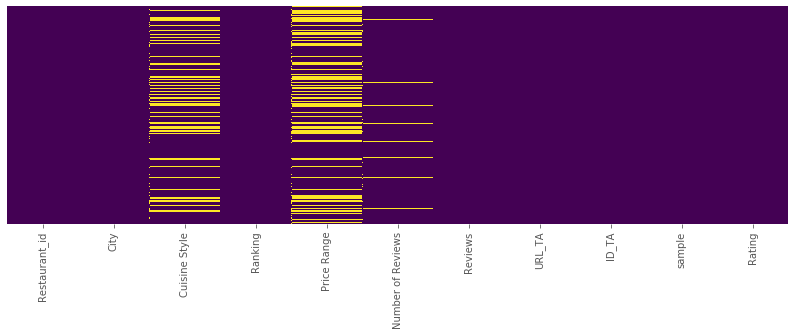

In [32]:
# Взглянем на пропуски графически
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis');

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [33]:
df['Number_of_Reviews_isNAN'] = pd.isna(
    df['Number of Reviews']).astype('uint8')
df['Cuisine Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Price Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df['Reviews_isNAN'] = pd.isna(df['Reviews']).astype('uint8')

In [34]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
df['Number of Reviews'].fillna(0, inplace=True)

In [35]:
# Напишем функцию, которая выведет всю статистическую инфу по переменной и строит графики
def analyse_numeric(datafr, column):
    '''Визуализирует распределение числовой переменной.
       Принимает параметрами DataFrame и строковое название столбца
       Печатает различные статистические показатели и строит гистограмму.'''
    count = datafr[column].count()
    mean = datafr[column].mean()
    std = datafr[column].std()
    median = datafr[column].median()
    perc25 = datafr[column].quantile(0.25)
    perc75 = datafr[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = datafr[column].min()
    range_max = datafr[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = datafr[column].loc[(
        datafr[column] < perc25 - 1.5*IQR) | (datafr[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(
        count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(datafr[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(
        f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR), 'Количество выбросов: ', len(outliers))

    datafr[column].loc[datafr[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                  .hist(bins=30, range=range_, label='В границах выбросов')
    outliers.hist(bins=30, range=range_, label='Выбросы')

    plt.legend()

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [36]:
df.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
Cuisine Style_isNAN            2
Price Range_isNAN              2
Reviews_isNAN                  2
dtype: int64

### Restaurant_id

In [79]:
df.Restaurant_id.nunique()

13094

### city

In [38]:
df_count = df.City.value_counts()
df_count

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [39]:
# Добавим в наш датасет количество ресторанов по городам
df['quantity'] = df['City'].apply(lambda x: df_count[x])

Как известно, количество ресторанов зависит от многих факторов. Например, от количества населения, от того, является ли город столицей, от географических координатов и т.д. Эти факторы влияют в конечном итоге на рейтинг ресторана, поэтому стоит их учесть, чтобы наши оценки были максимально точными

In [40]:
population_dict = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}

In [41]:
df['population'] = df['City'].map(population_dict)

Удобнее смотреть на количество жителей в тыс. людей, а также плотность населения в городе. Учтём это

In [42]:
df['population'] = df['population'] / 1000
df['quantity_density'] = df.quantity / df.population

Добавим теперь категориальный признак - является ли столицей или нет

In [43]:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
            'Bratislava', 'Vienna', 'Rome', 'Madrid',
            'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
            'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
            'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']
# Здесь код закомментирован, так как числовой признак ухудшает MAE
# df['capital'] = df['city'].apply(lambda x: x in capitals).astype('uint8')

In [44]:
# Теперь нужно соотнести столицы по странам
countries_dict = {'Amsterdam': 'Netherlands',
                  'Athens': 'Greece',
                  'Barcelona': 'Spain',
                  'Berlin': 'Germany',
                  'Bratislava': 'Slovakia',
                  'Brussels': 'Belgium',
                  'Budapest': 'Hungary',
                  'Copenhagen': 'Denmark',
                  'Dublin': 'Ireland',
                  'Edinburgh': 'UK',
                  'Geneva': 'Switzerland',
                  'Hamburg': 'Germany',
                  'Helsinki': 'Finland',
                  'Krakow': 'Poland',
                  'Lisbon': 'Portugal',
                  'Ljubljana': 'Slovenia',
                  'London': 'UK',
                  'Luxembourg': 'Luxembourg',
                  'Lyon': 'France',
                  'Madrid': 'Spain',
                  'Milan': 'Italy',
                  'Munich': 'Germany',
                  'Oporto': 'Portugal',
                  'Oslo': 'Norway',
                  'Paris': 'France',
                  'Prague': 'Czechia',
                  'Rome': 'Italy',
                  'Stockholm': 'Sweden',
                  'Vienna': 'Austria',
                  'Warsaw': 'Poland',
                  'Zurich': 'Switzerland'}

df['country'] = df.apply(lambda row: countries_dict[row['City']], axis=1)

In [45]:
# Добавим дамми-переменные по городам
df = pd.concat([df, pd.get_dummies(df.City, prefix='City')], axis=1)
df.head(3)

Restaurant_id       City                                      Cuisine Style  \
0          id_0      Paris                                     ['Bar', 'Pub']   
1          id_1   Helsinki  ['European', 'Scandinavian', 'Gluten Free Opti...   
2          id_2  Edinburgh                            ['Vegetarian Friendly']   

   Ranking Price Range  Number of Reviews  \
0  12963.0    $$ - $$$                4.0   
1    106.0    $$ - $$$               97.0   
2    810.0    $$ - $$$               28.0   

                                             Reviews  \
0                                           [[], []]   
1  [['Very good reviews!', 'Fine dining in Hakani...   
2  [['Better than the Links', 'Ivy Black'], ['12/...   

                                              URL_TA      ID_TA  sample  ...  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0  ...   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0  ...   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0  ...   

   City_Munich  City_Oporto  City_Oslo  City_Paris  City_Prague  City_Rome  \
0            0            0          0           1            0          0   
1            0            0          0           0            0          0   
2            0            0          0           0            0          0   

   City_Stockholm  City_Vienna City_Warsaw  City_Zurich  
0               0            0           0            0  
1               0            0           0            0  
2               0            0           0            0  

[3 rows x 50 columns]

In [46]:
# Добавим широту и долготу городов
dict_Сity_lat = {'London': 51.5, 'Paris': 48.8667, 'Madrid': 40.4, 'Barcelona': 41.3833,
                 'Berlin': 52.5218, 'Milan': 45.47, 'Rome': 34.2662, 'Prague': 50.0833,
                 'Lisbon': 40.7752, 'Vienna': 43.2344, 'Amsterdam': 52.35, 'Brussels': 50.8333,
                 'Hamburg': 53.55, 'Munich': 48.1299, 'Lyon': 45.77, 'Stockholm': 59.3508,
                 'Budapest': 47.5, 'Warsaw': 41.2443, 'Dublin': 53.3331,
                 'Copenhagen': 55.6786, 'Athens': 37.9833, 'Edinburgh': 55.9483,
                 'Zurich': 47.38, 'Oporto': 41.15, 'Geneva': 46.21, 'Krakow': 50.06,
                 'Oslo': 59.9167, 'Helsinki': 60.1756, 'Bratislava': 48.15,
                 'Luxembourg': 49.6117, 'Ljubljana': 46.0553}
df['Сity_lat'] = df.apply(lambda row: dict_Сity_lat[row['City']], axis=1)
dict_Сity_lng = {'London': -0.1167, 'Paris': 2.3333, 'Madrid': -3.6834, 'Barcelona': 2.1834,
                 'Berlin': 13.4015, 'Milan': 9.205, 'Rome': 12.4833, 'Prague': 14.466,
                 'Lisbon': -9.1449, 'Vienna': 16.3666, 'Amsterdam': 4.9166, 'Brussels': 4.3333,
                 'Hamburg': 10, 'Munich': 11.575, 'Lyon': 4.83, 'Stockholm': 18.0973,
                 'Budapest': 19.0833, 'Warsaw': 21, 'Dublin': -6.2489,
                 'Copenhagen': 12.5635, 'Athens': 23.7333, 'Edinburgh': -3.2191,
                 'Zurich': 8.55, 'Oporto': -8.62, 'Geneva': 6.14, 'Krakow': 19.96,
                 'Oslo': 10.75, 'Helsinki': 24.9341, 'Bratislava': 17.117,
                 'Luxembourg': 6.13, 'Ljubljana': 14.515}
df['Сity_lng'] = df.apply(lambda row: dict_Сity_lng[row['City']], axis=1)

In [47]:
# Добавим данные по ВВП стране - это непосредственно влияет на количество посетителей и на качество ресторанов
dict_Economies = {'UK': 45741, 'France': 45893, 'Spain': 40172,
                  'Germany': 52386, 'Italy': 39676, 'Czech_c': 37340,
                  'Portugal': 32412, 'Austria': 52172, 'Holland': 56489,
                  'Belgium': 48327, 'Sweden': 53652, 'Romania': 26448,
                  'Poland': 32005, 'Ireland': 79617, 'Denmark': 52279,
                  'Greece': 29072, 'Scotland': 45741, 'Switzerland': 65010,
                  'Norway': 74357, 'Finland': 46596, 'Slovakia': 35136,
                  'Luxembourg': 106372, 'Slovenia': 36741, 'Hungary': 14225,
                  'Czechia': 20368, 'Netherlands': 48223}
df['Economy'] = df.apply(lambda row: dict_Economies[row['country']], axis=1)

In [48]:
# Добавим столбец Rest_density - сколько ресторанов приходится на человека в городе (плотность ресторанов):
df['quantity_density'] = df['quantity'] / df['population']

In [49]:
# Рассмотрим распределение ранга ресторанов по странам:
df.pivot_table(values=['Ranking'],
               index='country',
               aggfunc='mean').iplot(kind='bar', title='Распределение ранга ресторанов по странам')

Среди лидеров Великобритания, Франция и Испания, чуть отстают Италия с Германией. Ожидаемый результат

#### Cuisine style

In [77]:
# Добавим столбец с количеством представленных стилей кухонь в ресторане:
df['Cuisine Style'] = df['Cuisine Style'].fillna("['Other']")
df['Cuisine_count'] = df['Cuisine Style'].str[2:-2].str.split("', '").str.len()
df.Cuisine_count.describe()

count    50000.000000
mean         2.625320
std          1.824029
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: Cuisine_count, dtype: float64

In [59]:
# Рассмотрим расределение ранга ресторанов и количества отзывов в зависимости от количества кухонь:
df.pivot_table(values=['Ranking', 'Number of Reviews'],
               index='Cuisine_count',
               aggfunc='mean').iplot(kind='bar', title='Ранг ресторанов и количество отзывов в зависимости от количества кухонь')

Судя по графику, чем меньше кухонь у ресторана, чем выше рейтинг

### Ranking

Количество: 50000, Среднее: 3664.428, Стандартное отклонение: 3700.092.
Минимум: 1.0, 25-й перцентиль: 972.0, Медиана: 2278.0, 75-й перцентиль: 5241.0, Максимум: 16444.0, IQR: 4269.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5431.5, 11644.5]. Количество выбросов:  3075


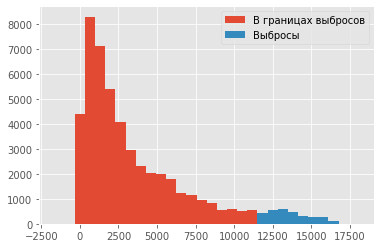

In [75]:
# Начнём с просмотра статистики
analyse_numeric(df, 'Ranking')

In [68]:
# Посмотрим на топ 5 городов:
(df['City'].value_counts())[0:5].index

Index(['London', 'Paris', 'Madrid', 'Barcelona', 'Berlin'], dtype='object')

In [69]:
# Взглянем на график
df[['London', 'Paris', 'Madrid', 'Barcelona', 'Berlin']].iplot(
    kind='hist', title='Распределение ранга по городам', bins=100)

Ресторанов очень много, поэтому чтобы действительно понять, является ли город лидером в рейтинге ресторанов, имеет смысл определить отношение рейтинга ресторана к количеству ресторанов в городе

In [73]:
df['Relative_rank'] = df['Ranking'] / df['quantity']
df['mean_ranking'] = df['Ranking'] / \
    df['City'].map(df.groupby(['City'])['Ranking'].max())
df.head(3)

Restaurant_id       City                                      Cuisine Style  \
0          id_0      Paris                                     ['Bar', 'Pub']   
1          id_1   Helsinki  ['European', 'Scandinavian', 'Gluten Free Opti...   
2          id_2  Edinburgh                            ['Vegetarian Friendly']   

   Ranking Price Range  Number of Reviews  \
0  12963.0    $$ - $$$                4.0   
1    106.0    $$ - $$$               97.0   
2    810.0    $$ - $$$               28.0   

                                             Reviews  \
0                                           [[], []]   
1  [['Very good reviews!', 'Fine dining in Hakani...   
2  [['Better than the Links', 'Ivy Black'], ['12/...   

                                              URL_TA      ID_TA  sample  ...  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0  ...   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0  ...   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0  ...   

   Сity_lng  Economy  Cuisine_count  London    Paris  Madrid  Barcelona  \
0    2.3333    45893              2     NaN  12963.0     NaN        NaN   
1   24.9341    46596              5     NaN      NaN     NaN        NaN   
2   -3.2191    45741              1     NaN      NaN     NaN        NaN   

   Berlin Relative_rank  mean_ranking  
0     NaN      2.122299      0.926855  
1     NaN      0.223158      0.092901  
2     NaN      1.087248      0.458664  

[3 rows x 61 columns]

### Rating

Количество: 50000, Среднее: 3.194, Стандартное отклонение: 1.705.
Минимум: 0.0, 25-й перцентиль: 3.0, Медиана: 4.0, 75-й перцентиль: 4.5, Максимум: 5.0, IQR: 1.5.
Количество пропусков в столбце:  0
Границы выбросов: [0.75, 6.75]. Количество выбросов:  10000


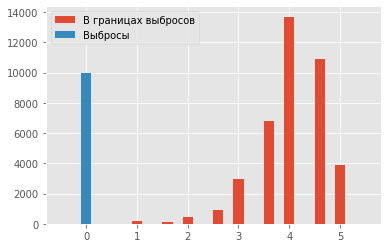

In [80]:
analyse_numeric(df, 'Rating')

In [82]:
# Взглянем на график распределения с помощью более качественного рисунка
df['Rating'].value_counts(ascending=True).iplot(
    kind='bar', title='Распределение рейтинга ресторанов')

Преобладает оценка 0. Вполне возможно, что просто ресторан не оценивали и просто заполнили нулём. Удалять их не будем пока что.

### Price Range

In [84]:
df['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [90]:
# Очень много пропусков. Обработаем их и заполним медианой
df['Price Range isna'] = pd.isna(df['Price Range']).astype('uint8')
df['Price Range label'] = df['Price Range'].apply(lambda x: 2.5 if pd.isnull(
    x) else 1.0 if x == '$' else 2.5 if x == '$$ - $$$' else 4.0)
df.head(3)

Restaurant_id       City                                      Cuisine Style  \
0          id_0      Paris                                     ['Bar', 'Pub']   
1          id_1   Helsinki  ['European', 'Scandinavian', 'Gluten Free Opti...   
2          id_2  Edinburgh                            ['Vegetarian Friendly']   

   Ranking Price Range  Number of Reviews  \
0  12963.0    $$ - $$$                4.0   
1    106.0    $$ - $$$               97.0   
2    810.0    $$ - $$$               28.0   

                                             Reviews  \
0                                           [[], []]   
1  [['Very good reviews!', 'Fine dining in Hakani...   
2  [['Better than the Links', 'Ivy Black'], ['12/...   

                                              URL_TA      ID_TA  sample  ...  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918       0  ...   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944       0  ...   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638       0  ...   

   Cuisine_count  London    Paris  Madrid  Barcelona  Berlin  Relative_rank  \
0              2     NaN  12963.0     NaN        NaN     NaN       2.122299   
1              5     NaN      NaN     NaN        NaN     NaN       0.223158   
2              1     NaN      NaN     NaN        NaN     NaN       1.087248   

   mean_ranking Price Range isna  Price Range label  
0      0.926855                0                2.5  
1      0.092901                0                2.5  
2      0.458664                0                2.5  

[3 rows x 63 columns]

Количество: 50000, Среднее: 2.319, Стандартное отклонение: 0.632.
Минимум: 1.0, 25-й перцентиль: 2.5, Медиана: 2.5, 75-й перцентиль: 2.5, Максимум: 4.0, IQR: 0.0.
Количество пропусков в столбце:  0
Границы выбросов: [2.5, 2.5]. Количество выбросов:  9598


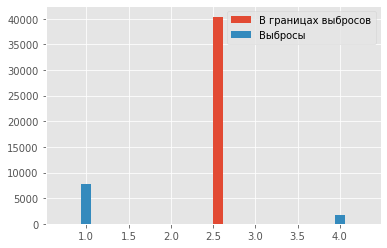

In [88]:
# Время красивых графиков
analyse_numeric(df, 'Price Range label')

In [89]:
df.pivot_table(values=['Price Range label'],
               index='City',
               aggfunc='mean').iplot(kind='bar', title='Уровень цен по ресторанам')

Уровень цен очень похож между странами (неплохой довод в пользу ППС)

### Number of Reviews


Количество: 50000, Среднее: 116.505, Стандартное отклонение: 286.173.
Минимум: 0.0, 25-й перцентиль: 7.0, Медиана: 28.0, 75-й перцентиль: 105.0, Максимум: 9660.0, IQR: 98.0.
Количество пропусков в столбце:  0
Границы выбросов: [-140.0, 252.0]. Количество выбросов:  5946


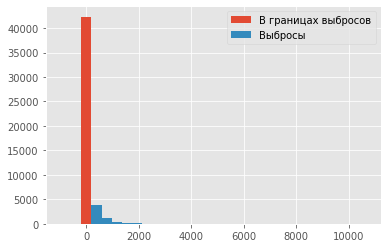

In [91]:
analyse_numeric(df, 'Number of Reviews')

In [92]:
df.pivot_table(values=['Number of Reviews'],
               index='Rating',
               aggfunc='mean').iplot(kind='bar', title='Распределение ранга от количества отзывов')

In [93]:
# Посмотрим распределение количества отзывов по городам:
df_reviews_by_city = df.groupby(
    ['City'])['Number of Reviews'].sum().sort_values(ascending=False)
df_reviews_by_city

City
London        933770.0
Rome          728235.0
Paris         680827.0
Milan         431350.0
Barcelona     429437.0
Madrid        357185.0
Prague        199875.0
Lisbon        196347.0
Amsterdam     193814.0
Edinburgh     172103.0
Berlin        155923.0
Budapest      148366.0
Dublin        122804.0
Brussels      113956.0
Vienna        106709.0
Lyon           93952.0
Munich         82386.0
Oporto         80355.0
Copenhagen     73670.0
Stockholm      71588.0
Athens         67765.0
Krakow         67635.0
Warsaw         55636.0
Hamburg        48853.0
Zurich         46769.0
Oslo           46602.0
Geneva         34071.0
Helsinki       29511.0
Luxembourg     20817.0
Ljubljana      18269.0
Bratislava     16672.0
Name: Number of Reviews, dtype: float64

In [94]:
df_reviews_by_city.sort_values().iplot(
    kind='bar', title='Количество отзывов о ресторанах по городам')

In [95]:
# Данные достаточно занимательные. Добавим их в датасет
df['Reviews in city'] = df['City'].apply(lambda x: df_reviews_by_city[x])

In [97]:
# Заполняем пропуски нулями
df['Number of Reviews'].fillna(0, inplace=True)

In [98]:
# Нормируем количество отзывов к населению города
df['Number of Reviews norm'] = df['Number of Reviews'] / df['population']

### Reviews

In [99]:
# Приведём для начала данные в более приличный вид
df['Reviews'] = df['Reviews'].fillna('[[], []]')

In [104]:
# Извлекем дату из ревью и создадим новые критерии:
df['Date_of_review'] = df['Reviews'].str.findall('\d+/\d+/\d+')
df['Len_date'] = df['Date_of_review'].apply(lambda x: len(x))
df[['Date_of_review', 'Reviews']].head()

Date_of_review                                            Reviews
0                        []                                           [[], []]
1  [12/05/2017, 10/29/2017]  [['Very good reviews!', 'Fine dining in Hakani...
2  [12/28/2017, 12/06/2017]  [['Better than the Links', 'Ivy Black'], ['12/...
3  [12/06/2017, 11/22/2017]  [['Most exquisite', 'Delicious and authentic']...
4  [02/08/2018, 01/24/2018]  [['Always the best in bratislava', 'Very good ...

In [109]:
# проверим длину даты поля
df.Date_of_review.apply(lambda x: len(x)).value_counts()

2    36202
0     8114
1     5680
3        4
Name: Date_of_review, dtype: int64

In [110]:
# Рассмотрим отзывы с тремя датами:
print("значения Reviews с тремя датами :=")
temp_list = df[df['Len_date'] == 3].Reviews.to_list()
display(df[df['Len_date'] == 3].Reviews.to_list())
display([re.findall('\d+/\d+/\d+', x) for x in temp_list])

значения Reviews с тремя датами :=


["[['We visited 21/10/17', 'Best Kebab in London'], ['12/22/2017', '10/19/2017']]",
 "[['Good Museum Cafeteria', 'Lunch 30/5/2017'], ['04/13/2017', '05/30/2017']]",
 "[['The desserts arcade !', 'Visit today 3/1/2017'], ['06/02/2017', '01/03/2017']]",
 "[['lunch 29/9/2016', 'Unplanned Great Dinner'], ['09/30/2016', '08/25/2016']]"]

[['21/10/17', '12/22/2017', '10/19/2017'],
 ['30/5/2017', '04/13/2017', '05/30/2017'],
 ['3/1/2017', '06/02/2017', '01/03/2017'],
 ['29/9/2016', '09/30/2016', '08/25/2016']]

In [111]:
# Видим что люди указывали даты в отзывах и эти даты попали в обработку, оставим даты вне отзывов:
df['Len_date'].Date_of_review = df[df['Len_date']
                                   == 3].Date_of_review.apply(lambda x: x.pop(0))

In [112]:
# Заполним перерыв между отзывами (по двум отзывам) и отследим насколько давно был сделан последний отзыв:
def time_to_now(row):
    if row['Date_of_review'] == []:
        return None
    return pd.datetime.now() - pd.to_datetime(row['Date_of_review']).max()


def time_between_reviews(row):
    if row['Date_of_review'] == []:
        return None
    return pd.to_datetime(row['Date_of_review']).max() - pd.to_datetime(row['Date_of_review']).min()


df['Day_to_now'] = df.apply(time_to_now, axis=1).dt.days
df['Day_between_reviews'] = df[df['Len_date'] == 2].apply(
    time_between_reviews, axis=1).dt.days

Количество: 36202, Среднее: 142.556, Стандартное отклонение: 222.565.
Минимум: 0.0, 25-й перцентиль: 20.0, Медиана: 67.0, 75-й перцентиль: 173.0, Максимум: 3296.0, IQR: 153.0.
Количество пропусков в столбце:  13798
Границы выбросов: [-209.5, 402.5]. Количество выбросов:  2920


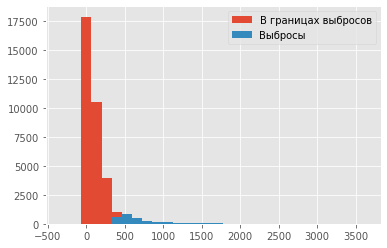

In [113]:
analyse_numeric(df, 'Day_between_reviews')

Количество: 41886, Среднее: 1208.045, Стандартное отклонение: 363.252.
Минимум: 918.0, 25-й перцентиль: 997.0, Медиана: 1071.0, 75-й перцентиль: 1255.0, Максимум: 5977.0, IQR: 258.0.
Количество пропусков в столбце:  8114
Границы выбросов: [610.0, 1642.0]. Количество выбросов:  4014


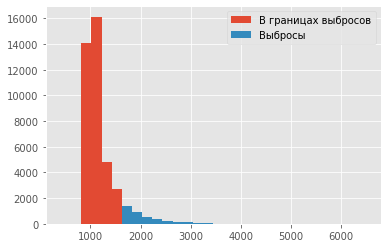

In [114]:
analyse_numeric(df, 'Day_to_now')

In [122]:
# Проверим количество пропусков в новых переменных
print('Пропусков в столбце с разницей между сегодняшним днём и последним отзывом: {}'.format(
    df['Day_to_now'].isna().sum()))
print('Пропусков в столбце с разницей между двумя отзывами: {}'.format(
    df['Day_between_reviews'].isna().sum()))

Пропусков в столбце с разницей между сегодняшним днём и последним отзывом: 8114
Пропусков в столбце с разницей между двумя отзывами: 13798


In [123]:
# Заполним пропуски нулями

df['Day_to_now'] = df['Day_to_now'].fillna(0)
df['Day_between_reviews'] = df['Day_between_reviews'].fillna(0)

In [125]:
# Создадим параметр Rev_year - год последнего отзыва.
# Для этого выделим из даты отзыва более свежий отзыв:
def last_review(row):
    if row == []:
        return None
    return pd.to_datetime(row).max()


df['Last_review'] = df['Date_of_review'].apply(last_review)

In [126]:
# Заполним пропуски минимальным значением:
df['Last_review'].min()

Timestamp('2004-04-21 00:00:00')

In [128]:
df['Last_review'] = df['Last_review'].apply(lambda x: '2004-04-21' if pd.isnull(x) else x)
df['Rev_year'] = df['Last_review'].dt.year

In [129]:
# Создадим параметр Rev_weekday - день недели последнего отзыва:
df['Rev_weekday'] = df['Last_review'].dt.dayofweek
df = df.drop(['Last_review'], axis = 1)

### Посмотрим распределение целевой переменной

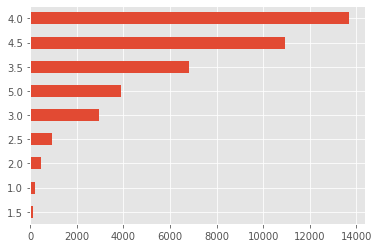

In [133]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Проведём корреляционный анализ

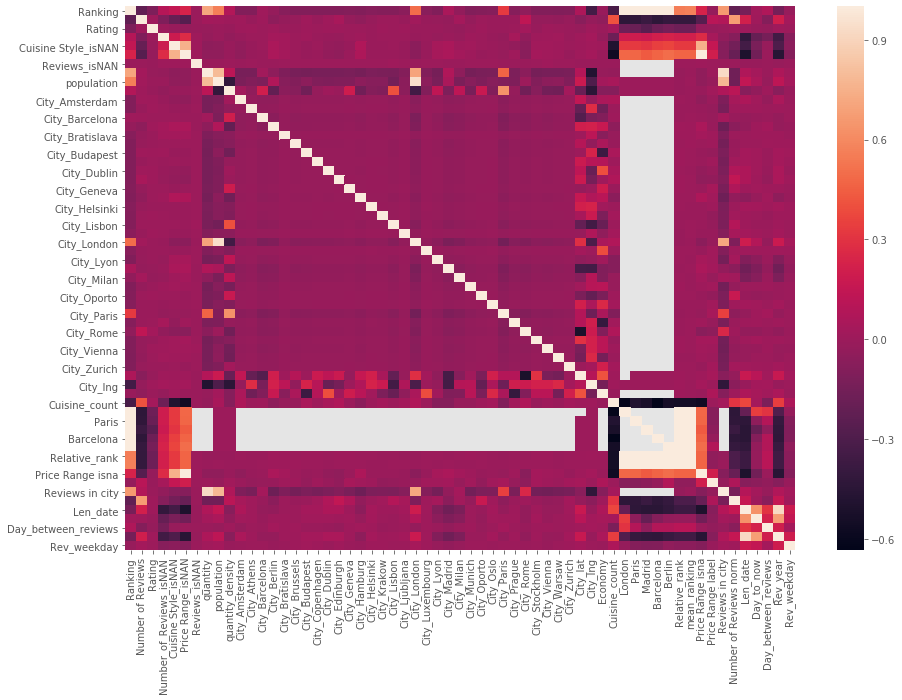

In [137]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [138]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [140]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [141]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

Ranking  Number of Reviews  sample  Rating  City_Amsterdam  \
1342    1649.0                9.0       0     0.0               0   
1411    6059.0              287.0       0     0.0               0   
2564     804.0               63.0       0     0.0               0   
26825   7444.0                4.0       1     2.5               0   
49067    855.0               25.0       1     4.0               0   
17130    891.0               11.0       1     4.5               0   
1421   12012.0                3.0       0     0.0               0   
36576   5871.0                0.0       1     4.0               0   
14865    755.0               71.0       1     4.5               0   
19204   1299.0                0.0       1     4.0               0   

       City_Athens  City_Barcelona  City_Berlin  City_Bratislava  \
1342             0               0            0                0   
1411             0               0            1                0   
2564             0               0            0                0   
26825            0               1            0                0   
49067            1               0            0                0   
17130            0               0            0                0   
1421             0               0            0                0   
36576            0               0            0                0   
14865            0               0            0                0   
19204            0               0            0                0   

       City_Brussels  ...  City_Oporto  City_Oslo  City_Paris  City_Prague  \
1342               0  ...            0          0           0            0   
1411               0  ...            0          0           0            0   
2564               0  ...            0          0           0            0   
26825              0  ...            0          0           0            0   
49067              0  ...            0          0           0            0   
17130              0  ...            0          0           0            0   
1421               0  ...            0          0           1            0   
36576              0  ...            0          0           0            0   
14865              0  ...            0          0           0            0   
19204              0  ...            0          0           0            0   

       City_Rome  City_Stockholm  City_Vienna  City_Warsaw  City_Zurich  \
1342           0               1            0            0            0   
1411           0               0            0            0            0   
2564           0               1            0            0            0   
26825          0               0            0            0            0   
49067          0               0            0            0            0   
17130          0               0            0            1            0   
1421           0               0            0            0            0   
36576          0               0            0            0            0   
14865          0               0            0            0            0   
19204          0               0            0            0            1   

       City_nan  
1342          0  
1411          0  
2564          0  
26825         0  
49067         0  
17130         0  
1421          0  
36576         0  
14865         0  
19204         0  

[10 rows x 36 columns]

In [142]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Number of Reviews  50000 non-null  float64
 2   sample             50000 non-null  int64  
 3   Rating             50000 non-null  float64
 4   City_Amsterdam     50000 non-null  uint8  
 5   City_Athens        50000 non-null  uint8  
 6   City_Barcelona     50000 non-null  uint8  
 7   City_Berlin        50000 non-null  uint8  
 8   City_Bratislava    50000 non-null  uint8  
 9   City_Brussels      50000 non-null  uint8  
 10  City_Budapest      50000 non-null  uint8  
 11  City_Copenhagen    50000 non-null  uint8  
 12  City_Dublin        50000 non-null  uint8  
 13  City_Edinburgh     50000 non-null  uint8  
 14  City_Geneva        50000 non-null  uint8  
 15  City_Hamburg       50000 non-null  uint8  
 16  City_Helsinki      500

In [143]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [144]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [145]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 35), (40000, 35), (40000, 34), (32000, 34), (8000, 34))

# Model 
Сам ML

In [146]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [147]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [148]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [149]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.215194375


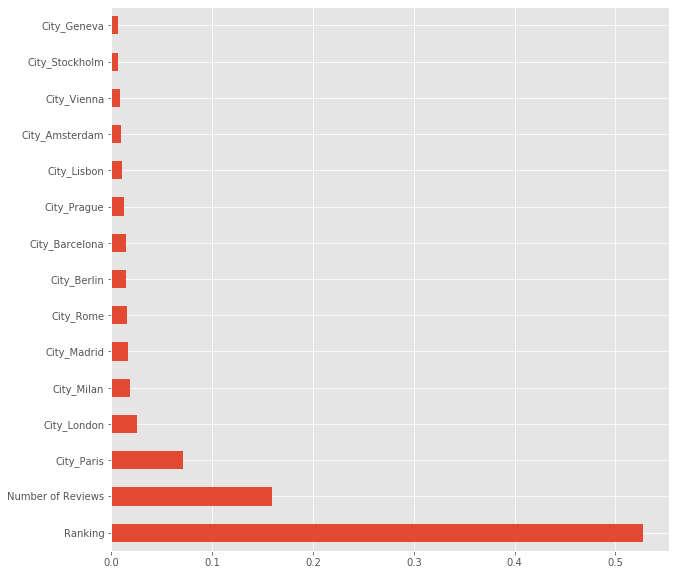

In [150]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [151]:
test_data.sample(10)

Ranking  Number of Reviews  Rating  City_Amsterdam  City_Athens  \
4714    748.0               38.0     0.0               0            0   
9111   1663.0               14.0     0.0               0            0   
2830   7542.0               92.0     0.0               0            0   
2486    455.0              197.0     0.0               0            0   
8235  12666.0                0.0     0.0               0            0   
9706   2695.0               11.0     0.0               0            0   
3992    707.0              154.0     0.0               0            0   
1737   3041.0                6.0     0.0               1            0   
4175   2000.0               27.0     0.0               0            0   
7007    930.0               38.0     0.0               0            0   

      City_Barcelona  City_Berlin  City_Bratislava  City_Brussels  \
4714               0            0                0              0   
9111               0            1                0              0   
2830               0            0                0              0   
2486               0            0                0              1   
8235               0            0                0              0   
9706               0            0                0              0   
3992               0            0                0              0   
1737               0            0                0              0   
4175               0            1                0              0   
7007               0            0                0              0   

      City_Budapest  ...  City_Oporto  City_Oslo  City_Paris  City_Prague  \
4714              0  ...            0          0           0            0   
9111              0  ...            0          0           0            0   
2830              0  ...            0          0           0            0   
2486              0  ...            0          0           0            0   
8235              0  ...            0          0           0            0   
9706              0  ...            0          0           0            1   
3992              0  ...            0          0           0            1   
1737              0  ...            0          0           0            0   
4175              0  ...            0          0           0            0   
7007              0  ...            0          0           0            0   

      City_Rome  City_Stockholm  City_Vienna  City_Warsaw  City_Zurich  \
4714          0               0            0            0            0   
9111          0               0            0            0            0   
2830          0               0            0            0            0   
2486          0               0            0            0            0   
8235          0               0            0            0            0   
9706          0               0            0            0            0   
3992          0               0            0            0            0   
1737          0               0            0            0            0   
4175          0               0            0            0            0   
7007          0               0            0            0            0   

      City_nan  
4714         0  
9111         0  
2830         0  
2486         0  
8235         0  
9706         0  
3992         0  
1737         0  
4175         0  
7007         0  

[10 rows x 35 columns]

In [152]:
test_data = test_data.drop(['Rating'], axis=1)

In [153]:
sample_submission

Restaurant_id  Rating
0             id_0     2.0
1             id_1     2.5
2             id_2     4.0
3             id_3     1.0
4             id_4     4.0
...            ...     ...
9995       id_9995     3.0
9996       id_9996     1.5
9997       id_9997     4.5
9998       id_9998     1.0
9999       id_9999     2.5

[10000 rows x 2 columns]

In [154]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [155]:
predict_submission

array([3.125, 4.215, 4.535, ..., 3.   , 4.495, 4.155])

In [156]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

Restaurant_id  Rating
0          id_0   3.125
1          id_1   4.215
2          id_2   4.535
3          id_3   4.195
4          id_4   4.470
5          id_5   4.220
6          id_6   1.075
7          id_7   3.260
8          id_8   4.035
9          id_9   4.720